In [1]:
%matplotlib inline
%precision 3

import montecarlo
import plot
import metrics
from decimal import Decimal
import simulate
import pandas
import numpy
from pprint import pprint
import metrics
import withdrawal
import harvesting
import mortality

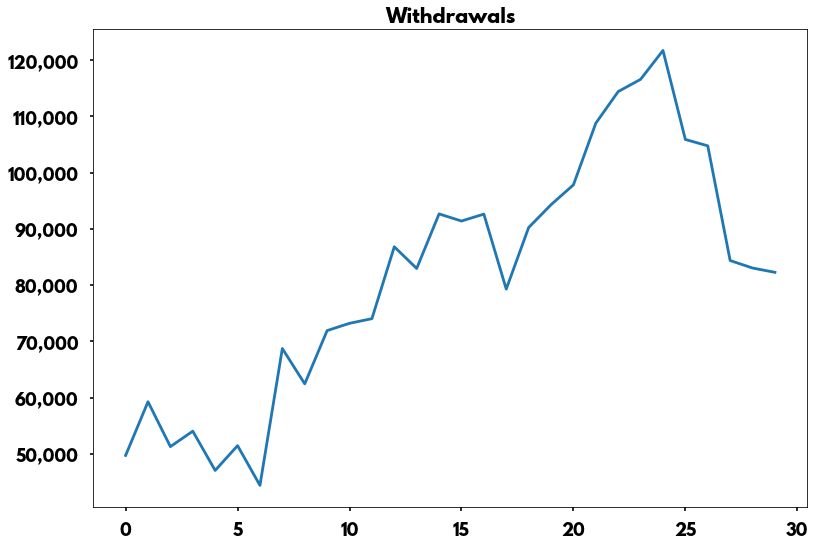

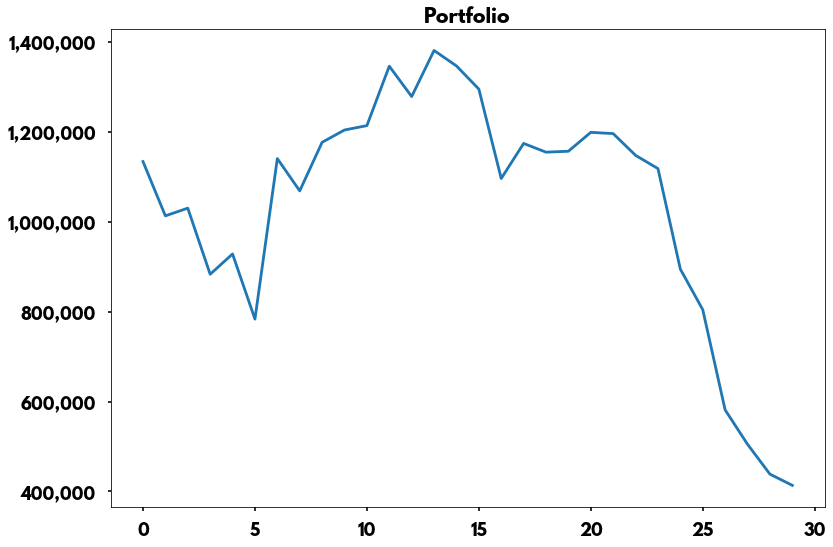

In [5]:
r = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), years=30, withdraw=withdrawal.VPW)
plot.plot([n.withdraw_r for n in r], title='Withdrawals')
plot.plot([n.portfolio_post.value_r for n in r], title='Portfolio')
#plot.plot([n.returns for n in r], title='Returns', add_commas=False, zero_based=False)

In [7]:
#pprint(['%.2f' % float(n.returns) for n in r[1:]])

In [8]:
def harness(iters, sim):
    successes = 0
    incomes = pandas.Series(iters)
    for i in range(iters):
        sim_results = sim()
        incomes.loc[i] = float(metrics.cew([(n.withdraw_pct_orig * 100) + Decimal('.01') for n in sim_results]))
        if sim_results[-1].portfolio_pre.value_n > 0:
            successes += 1
    return (successes/iters, incomes)

def p_q(incomes):
    print('90th percentile income', incomes.quantile(.9))
    print('50th percentile income', incomes.quantile(.5))
    print('10th percentile income', incomes.quantile(.1))
    print('5th percentile income', incomes.quantile(.05))
    print('1st percentile income', incomes.quantile(.01))   

In [11]:
iters = 50
EM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsHighValuations(), years=30))
VPW = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsHighValuations(),harvesting=harvesting.N_60_RebalanceHarvesting, withdraw=withdrawal.VPW, years=30))
#ECM = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsAutoRegression(), withdraw=withdrawal.ECM, years=30))
VG = harness(iters, lambda: simulate.withdrawals(montecarlo.LowYieldsHighValuations(), withdraw=withdrawal.Vanguard, years=30))

In [12]:
for i in (EM, VG, VPW):
    print('Success rate', i[0])
    p_q(i[1])
    print()

Success rate 0.68
90th percentile income 3.978151369526181
50th percentile income 2.6808484179936745
10th percentile income 0.014388178052591159
5th percentile income 0.013915788415808678
1st percentile income 0.013174818588822152

Success rate 0.62
90th percentile income 3.777411463795513
50th percentile income 2.6266391975933407
10th percentile income 0.012823206077080172
5th percentile income 0.012437318231114346
1st percentile income 0.01199344959858207

Success rate 1.0
90th percentile income 3.959712335790503
50th percentile income 2.7704605228054437
10th percentile income 1.4525201487687576
5th percentile income 1.2503232383426461
1st percentile income 1.0469183785187428



In [13]:
def run_one(years, stock_pct, a=None):
    bond_pct = (1 - stock_pct)
    
    if not a:
        a = montecarlo.LowYieldsAutoRegression(initial_yield=.02697)
    
    returns = []
    
    for i, j in zip(range(years+1), a):
        stocks = float(j.stocks - j.inflation)
        bonds = float(j.bonds - j.inflation)
        total_return = (stocks * stock_pct) + (bonds * bond_pct)
        returns.append(total_return)
    return returns

In [14]:
a = montecarlo.LowYieldsAutoRegression(initial_yield=.025, logging=True)
run_one(30, .6, a=a)
print('inflation', a.log['inflation'].mean())
print('stocks', a.log['stocks'].mean())
print('bonds', a.log['bonds'].mean())
print('-' * 65)
print(a.log)

inflation 0.021058507024293693
stocks 0.07578724988413665
bonds 0.03159873814291293
-----------------------------------------------------------------
      y_prev     y_new        rc    stocks     bonds  inflation
0   0.025000  0.029266  0.009100 -0.111542  0.058051   0.018704
1   0.029266  0.019123  0.000000 -0.307020  0.150837   0.009324
2   0.019123  0.030112  0.013561  0.250627  0.073339   0.053546
3   0.030112  0.027527  0.013367  0.069012  0.079606  -0.001387
4   0.027527  0.033482  0.001540  0.350813  0.001217   0.006105
5   0.033482  0.046284  0.021901  0.116029 -0.016959   0.003298
6   0.046284  0.036341  0.023198  0.251215  0.147677   0.040716
7   0.036341  0.029991  0.000000  0.259892  0.034795  -0.017059
8   0.029991  0.043984  0.041202 -0.114903  0.136807   0.015451
9   0.043984  0.041083  0.038018  0.264749  0.014595   0.032752
10  0.041083  0.044237  0.027733  0.470563 -0.019746   0.038635
11  0.044237  0.026258  0.003085  0.242365  0.139612   0.019691
12  0.026258  0.01

In [15]:
iters = 5000

s = pandas.Series(iters)

for i in range(iters):
    years = 30
    stock_pct = .6
    ssr = metrics.ssr([Decimal(n) for n in run_one(years, stock_pct)])
    s[i] = float(ssr)

In [16]:
s.median()
s.quantile(.05)

0.02743270796660507

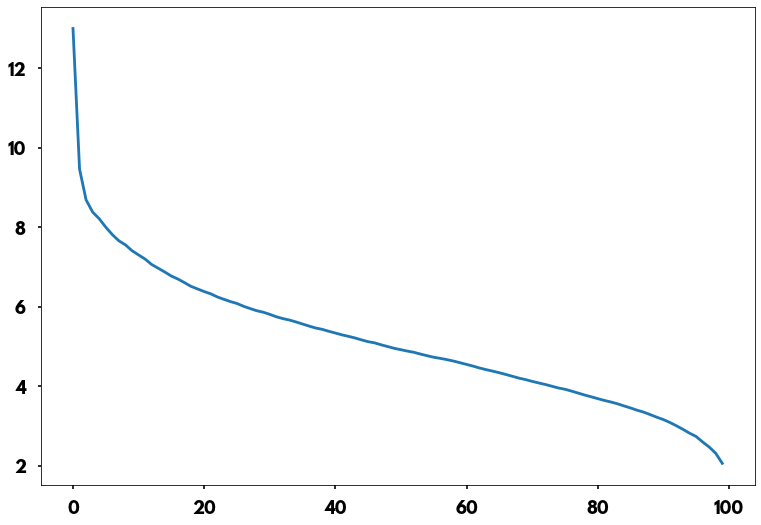

In [17]:
rates = pandas.Series(100)
for i in range(0, 100):
    q = s.quantile((100-i)/100)
    rates[i] = q * 100
rates.plot()

In [19]:
survival_fn = mortality.make_mortality(mortality.NVSS_2011)
iters = 1000
successes = 0
for i in range(iters):
    lifespan = mortality.gen_lifespan(mortality.DEFAULT_COUPLE, survival_fn=survival_fn)
    sim_results = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(),
                         harvesting=harvesting.make_rebalancer(.6),
                         withdraw=withdrawal.ConstantDollar,
                         years=lifespan)
    if sim_results[-1].portfolio_post.value_n > 0:
        successes += 1
print(successes/iters)

0.836


In [20]:
survival_fn = mortality.make_mortality(mortality.NVSS_2011)
iters = 1000
successes = 0
failures = 0
years_to_failure = []
portfolio_at_10 = []
for i in range(iters):
    lifespan = mortality.gen_lifespan(mortality.DEFAULT_COUPLE, survival_fn=survival_fn)
    sim_results = simulate.withdrawals(montecarlo.LowYieldsAutoRegression(),
                         harvesting=harvesting.make_rebalancer(1),
                         withdraw=lambda p,h: withdrawal.ConstantDollar(p, h, rate=Decimal('.04')),
                         years=lifespan)

    # only count iterations where the initial 5 year return was at
    # least equal to what we've experienced.
    cumulative = pandas.Series([x.returns + 1 for x in sim_results[1:6]])
    if numpy.prod(cumulative) - 1 < 1.03660168511777: continue

    if sim_results[-1].portfolio_post.value_n > 0:
        successes += 1
    else:
        failures += 1
        years_to_failure.append(len(list(filter(lambda x: x.portfolio_r > 0, sim_results))))
        portfolio_at_10.append(sim_results[9].portfolio_r)
print(successes/(successes + failures))

AttributeError: 'YearlyResults' object has no attribute 'returns'

In [28]:
fail = pandas.Series(years_to_failure)
len(fail[fail < 20])

1

In [29]:
p = pandas.Series(portfolio_at_10)

In [30]:
p

0    852013.9564266876228701040990
1    407129.5412869744888740544522
dtype: object

In [31]:
import numpy
import scipy.stats

iters = 5000
df = pandas.DataFrame(columns=numpy.arange(iters))

for i in range(iters):
    engine = montecarlo.LowYieldsAutoRegression()
    
    returns = []
    for j in range(5):
        returns.append(float(engine.random_year().stocks) + 1)
    series = pandas.Series(returns)
    
    df[i] = series

cumulative_returns = df.apply(lambda x: numpy.prod(x) - 1)

scipy.stats.percentileofscore(cumulative_returns, 1.03660168511777) # returns from 2011 - 2017 (inclusive)

81.880

In [32]:
cumulative_returns.quantile(0.5)

0.418